# Connect-4 Supervised Pretraining (CNet192)

Imitate a (lookahead) teacher policy from an Excel dataset.

**Input encoding (1 channel, POV):**
- empty = 0
- current player = +1
- opponent = -1


In [1]:
# Imports & config
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split
from C4.CNet192 import CNet192, save_cnet192, load_cnet192

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# ---- Paths ----
DATA_FILES = [
    "DATA/C4.train_data_expert.xlsx",
    "DATA/C4.train_data_topshit.xlsx",
    "DATA/C4.train_data_prohpet.xlsx",
    "DATA/C4.train_data_prophet_v2.xlsx",
    "DATA/C4.train_data_prophet_v3.xlsx",
    "DATA/C4.train_data_prophet_v4.xlsx",
    "DATA/C4.train_data_prophet_vs_random.xlsx",
    "DATA/C4.train_data_numba.xlsx",
    "DATA/C4.train_data_parity_opening_book.xlsx",
    "DATA/C4.train_data_zug.xlsx",
    "DATA/C4.train_data_zug_opt.xlsx",
    "DATA/C4.train_data_zug_kaggle_optimized.xlsx",
]

OUT_DIR = Path("./out_supervised")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Training knobs ----
BATCH_SIZE = 64 #25
EPOCHS = 50 #25
LR = 5e-4 #5e-4 
WEIGHT_DECAY = 2e-3 #2e-3
VAL_FRAC = 0.10
TEST_FRAC = 0.10
USE_SOFT_LABELS = True

SEED = 666*13
torch.manual_seed(SEED)
np.random.seed(SEED)


DEVICE: cuda


In [2]:
# Load Excel dataset(s)
def load_excel_rows(paths):
    dfs = []
    for p in paths:
        df = pd.read_excel(p)
        df["__source__"] = str(p)
        dfs.append(df)
    if not dfs: raise ValueError("DATA_FILES is empty — add at least one .xlsx path.")
    return pd.concat(dfs, ignore_index=True)

df = load_excel_rows(DATA_FILES)

print("Rows:", len(df))
print("Columns:", len(df.columns))
print(df.columns.tolist()[:20], "...")

Rows: 1245647
Columns: 56
['label', 'reward', 'game', 'ply', 'action', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'player', '0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '0-6'] ...


In [3]:
# Dataset (1-channel POV)
BOARD_ROWS, BOARD_COLS = 6, 7
CELL_COLS = [f"{r}-{c}" for r in range(BOARD_ROWS) for c in range(BOARD_COLS)]

def to_minus1_plus1(board_6x7: np.ndarray) -> np.ndarray:
    # Accept {0,1,2} or {0,1,-1}; normalize to {0,1,-1}
    b = board_6x7.astype(np.int8, copy=True)
    b[b == 2] = -1
    return b

class C4SupervisedDataset(Dataset):
    def __init__(self, df: pd.DataFrame, use_soft_labels: bool = True):
        self.df = df.reset_index(drop=True)
        self.has_probs = all(f"p{i}" in df.columns for i in range(7))

        missing = [c for c in (CELL_COLS + ["action", "player"]) if c not in df.columns]
        if missing: raise ValueError(f"Missing required columns: {missing[:10]}" + (" ..." if len(missing) > 10 else ""))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        board = row[CELL_COLS].to_numpy(dtype=np.int8).reshape(BOARD_ROWS, BOARD_COLS)
        board = to_minus1_plus1(board)

        player = int(row["player"])  # +1 or -1
        board_pov = (board * player).astype(np.float32)

        x = torch.from_numpy(board_pov).unsqueeze(0)  # (1,6,7)
        y_action = int(row["action"])

        if self.has_probs:
            p = np.array([float(row[f"p{i}"]) for i in range(7)], dtype=np.float32)
            s = float(p.sum())
            if s <= 1e-12:
                p[:] = 1.0 / 7.0
            else:
                p /= s
            y_probs = torch.from_numpy(p)
        else:
            y_probs = torch.zeros(7, dtype=torch.float32)

        return x, y_action, y_probs


ds = C4SupervisedDataset(df, use_soft_labels=USE_SOFT_LABELS)

n_total = len(ds)
n_test = int(n_total * TEST_FRAC)
n_val  = int(n_total * VAL_FRAC)
n_train = n_total - n_val - n_test

ds_train, ds_val, ds_test = random_split(
    ds,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(SEED)
)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print("Train/Val/Test:", len(ds_train), len(ds_val), len(ds_test))


Train/Val/Test: 996519 124564 124564


In [4]:
# Model: CNet192 with optional 3x3 in-between

model = CNet192(use_mid_3x3=True).to(DEVICE)
print(model)
print("Flatten size:", model.flat)
summary(model)

CNet192(
  (conv1): Conv2d(1, 192, kernel_size=(4, 4), stride=(1, 1))
  (conv_mid): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(192, 192, kernel_size=(2, 2), stride=(1, 1))
  (fc): Linear(in_features=1152, out_features=192, bias=True)
  (policy_fc): Linear(in_features=192, out_features=192, bias=True)
  (policy_out): Linear(in_features=192, out_features=7, bias=True)
  (value_fc): Linear(in_features=192, out_features=192, bias=True)
  (value_out): Linear(in_features=192, out_features=1, bias=True)
)
Flatten size: 1152


Layer (type:depth-idx)                   Param #
CNet192                                  --
├─Conv2d: 1-1                            3,264
├─Conv2d: 1-2                            331,968
├─Conv2d: 1-3                            147,648
├─Linear: 1-4                            221,376
├─Linear: 1-5                            37,056
├─Linear: 1-6                            1,351
├─Linear: 1-7                            37,056
├─Linear: 1-8                            193
Total params: 779,912
Trainable params: 779,912
Non-trainable params: 0

In [5]:
# Losses, optimizer, helpers
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def policy_loss_from_soft_targets(logits, target_probs):
    # cross-entropy with soft labels: -sum(p * log_softmax)
    logp = F.log_softmax(logits, dim=1)
    return -(target_probs * logp).sum(dim=1).mean()

@torch.no_grad()
def batch_accuracy(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

@torch.no_grad()
def teacher_best_mask(y_probs, eps: float = 1e-12):
    # best set = argmax set (ties allowed)
    best = y_probs.max(dim=1, keepdim=True).values
    return y_probs >= (best - eps)

@torch.no_grad()
def batch_in_best_accuracy(logits, y_probs, eps: float = 1e-12):
    """
    Teacher-optimal move hit rate:
    fraction where argmax(logits) lands in teacher's argmax set.
    """
    pred = logits.argmax(dim=1)  # (B,)
    best_mask = teacher_best_mask(y_probs, eps=eps)  # (B,7)
    hit = best_mask[torch.arange(pred.size(0), device=pred.device), pred]
    return hit.float().mean().item()

@torch.no_grad()
def batch_topk_inbest(logits, y_probs, k=2, eps=1e-12):
    """
    Top-k teacher-optimal hit rate:
    fraction where ANY of model's top-k actions lands in teacher's argmax set.
    """
    best_mask = teacher_best_mask(y_probs, eps=eps)         # (B,7)
    topk = logits.topk(k, dim=1).indices                    # (B,k)
    hits = best_mask.gather(1, topk).any(dim=1)             # (B,)
    return hits.float().mean().item()

def train_one_epoch():
    model.train()
    tot_loss = tot_acc = tot_inbest = tot_top2 = n = 0

    for x, y_action, y_probs in dl_train:
        x = x.to(DEVICE, non_blocking=True)
        y_action = y_action.to(DEVICE, non_blocking=True)
        y_probs = y_probs.to(DEVICE, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        logits, _ = model(x)

        if USE_SOFT_LABELS:
            loss = policy_loss_from_soft_targets(logits, y_probs)
        else:
            loss = F.cross_entropy(logits, y_action)

        loss.backward()
        opt.step()

        b = x.size(0)
        tot_loss   += loss.item() * b
        tot_acc    += batch_accuracy(logits, y_action) * b
        tot_inbest += batch_in_best_accuracy(logits, y_probs) * b
        tot_top2   += batch_topk_inbest(logits, y_probs, k=2) * b
        n += b

    return tot_loss / n, tot_acc / n, tot_inbest / n, tot_top2 / n

@torch.no_grad()
def eval_loader(dl):
    model.eval()
    tot_loss = tot_acc = tot_inbest = tot_top2 = n = 0

    for x, y_action, y_probs in dl:
        x = x.to(DEVICE, non_blocking=True)
        y_action = y_action.to(DEVICE, non_blocking=True)
        y_probs = y_probs.to(DEVICE, non_blocking=True)

        logits, _ = model(x)

        if USE_SOFT_LABELS:
            loss = policy_loss_from_soft_targets(logits, y_probs)
        else:
            loss = F.cross_entropy(logits, y_action)

        b = x.size(0)
        tot_loss   += loss.item() * b
        tot_acc    += batch_accuracy(logits, y_action) * b
        tot_inbest += batch_in_best_accuracy(logits, y_probs) * b
        tot_top2   += batch_topk_inbest(logits, y_probs, k=2) * b
        n += b

    return tot_loss / n, tot_acc / n, tot_inbest / n, tot_top2 / n


In [6]:
%%time
# Train loop + save best 
from tqdm.auto import trange

best_val = -1.0
best_path = OUT_DIR / "cnet192_best.pt"

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_inbest": [],
    "val_inbest": [],
    "train_top2_inbest": [],
    "val_top2_inbest": [],
}


pbar = trange(1, EPOCHS + 1, desc="Supervised", leave=True,  dynamic_ncols=True)
for epoch in pbar:
    tr_loss, tr_acc, tr_inbest, tr_top2 = train_one_epoch()
    va_loss, va_acc, va_inbest, va_top2 = eval_loader(dl_val)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    history["train_inbest"].append(tr_inbest)
    history["val_inbest"].append(va_inbest)
    history["train_top2_inbest"].append(tr_top2)
    history["val_top2_inbest"].append(va_top2)

    pbar.set_postfix({
        "tr_loss": f"{tr_loss:.4f}",
        "tr_acc":  f"{tr_acc:.4f}",
        "va_acc":  f"{va_acc:.4f}",
        "va_inb":  f"{va_inbest:.4f}",
        "va_t2":   f"{va_top2:.4f}",
        "best":    f"{best_val:.4f}",
    })

    if va_inbest > best_val:
        best_val = va_inbest

        cfg = {
                "pov_encoding": True,
                "trained_with_soft": bool(USE_SOFT_LABELS),
            }

        save_cnet192(best_path,model,cfg=cfg,best_val_inbest=float(best_val),best_val_top2=float(va_top2),best_val_acc=float(va_acc),epoch=int(epoch))

        pbar.write(f"Saved best -> {best_path} (val_inbest={best_val:.4f}), epoch: {epoch}")


Supervised:   0%|          | 0/50 [00:00<?, ?it/s]

Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8559)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8761)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8843)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8891)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8905)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8923)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8947)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8959)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8960)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8978)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8981)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8989)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8990)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8993)
Saved best -> out_supervised\cnet192_best.pt (val_inbest=0.8997)
Saved best -> out_supervi

In [7]:
test_loss, test_acc, test_inbest, test_top2 = eval_loader(dl_test)

print("\n=== FINAL TEST RESULTS ===")
print(f"test loss    : {test_loss:.6f}")
print(f"test acc     : {test_acc:.4f}   (hard label)")
print(f"test inbest  : {test_inbest:.4f} (teacher-optimal hit rate)")
print(f"test top2    : {test_top2:.4f}   (teacher-optimal in top-2)")

# last best

# === FINAL TEST RESULTS ===
# test loss    : 0.522305
# test acc     : 0.7855   (hard label)
# test inbest  : 0.9140 (teacher-optimal hit rate)
# test top2    : 0.9780   (teacher-optimal in top-2)




=== FINAL TEST RESULTS ===
test loss    : 0.490483
test acc     : 0.7869   (hard label)
test inbest  : 0.9025 (teacher-optimal hit rate)
test top2    : 0.9737   (teacher-optimal in top-2)


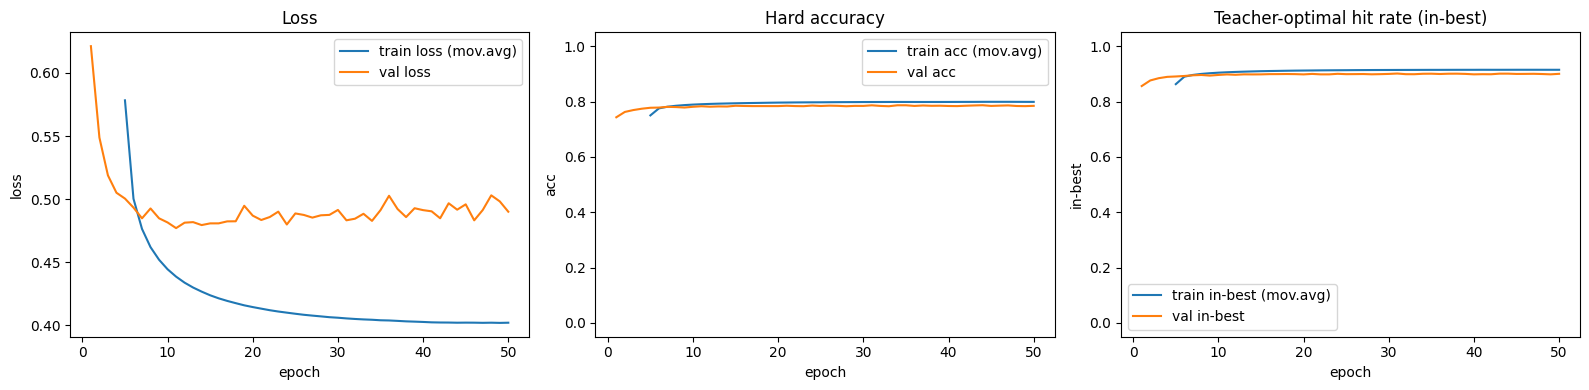

In [8]:
moving = 5

train_x = np.arange(1, len(history["train_loss"]) + 1)
val_x   = train_x

def moving_average(data, m):
    data = list(data)
    if len(data) < m:
        return data[:]
    return [np.mean(data[i:i+m]) for i in range(len(data) - m + 1)]

avg_tr_loss = moving_average(history["train_loss"], moving)
avg_tr_acc  = moving_average(history["train_acc"], moving)
avg_tr_best = moving_average(history["train_inbest"], moving)

avg_x = np.arange(moving, len(history["train_loss"]) + 1) if len(history["train_loss"]) >= moving else train_x

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 4))

# Loss
ax0.plot(avg_x, avg_tr_loss, label="train loss (mov.avg)")
ax0.plot(val_x, history["val_loss"], label="val loss")
ax0.set_title("Loss")
ax0.set_xlabel("epoch")
ax0.set_ylabel("loss")
ax0.legend()

# Hard accuracy
ax1.plot(avg_x, avg_tr_acc, label="train acc (mov.avg)")
ax1.plot(val_x, history["val_acc"], label="val acc")
ax1.set_title("Hard accuracy")
ax1.set_xlabel("epoch")
ax1.set_ylabel("acc")
ax1.set_ylim(-0.05, 1.05)
ax1.legend()

# In-best accuracy
ax2.plot(avg_x, avg_tr_best, label="train in-best (mov.avg)")
ax2.plot(val_x, history["val_inbest"], label="val in-best")
ax2.set_title("Teacher-optimal hit rate (in-best)")
ax2.set_xlabel("epoch")
ax2.set_ylabel("in-best")
ax2.set_ylim(-0.05, 1.05)
ax2.legend()

plt.tight_layout()
plt.show()


In [9]:
# Quick sanity check (predict a few samples)
@torch.no_grad()
def show_predictions(n_show=8):
    model.eval()
    xs, ys, ps = next(iter(dl_val))
    xs = xs[:n_show].to(DEVICE)
    ys = ys[:n_show].numpy()

    logits, _ = model(xs)
    pred = logits.argmax(dim=1).cpu().numpy()

    out = pd.DataFrame({"y_action": ys, "pred": pred})
    return out

show_predictions(16)


,y_action,pred
0,4,4
1,3,3
2,5,4
3,4,4
4,5,5
5,6,6
6,0,0
7,3,3
8,5,5
9,1,1


,n,acc,top2_acc
0,124564,0.784336,0.926046


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6
y0,14643,396,600,359,1123,245,329
y1,891,12675,798,524,1272,239,235
y2,623,289,14611,1884,1115,614,224
y3,236,255,606,14744,761,271,134
y4,234,235,595,1877,15636,204,153
y5,618,1070,690,548,969,12533,421
y6,1602,566,776,442,1171,670,12858


,in_top2_0,in_top2_1,in_top2_2,in_top2_3,in_top2_4,in_top2_5,in_top2_6
y0,16578,4341,2306,1372,3547,2758,4488
y1,3562,15310,2947,2097,3707,3057,2588
y2,2942,2717,18056,4635,4597,3302,2471
y3,1647,1782,6916,16173,4210,1676,1610
y4,2633,4405,3892,4099,17622,2621,2596
y5,2979,3702,2843,1774,4359,15312,2729
y6,4664,3006,3183,1644,3964,3408,16301


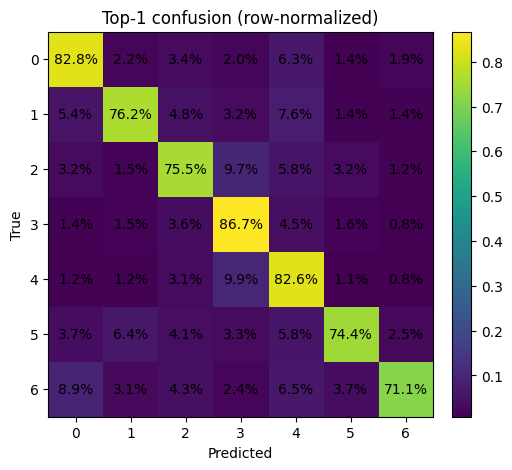

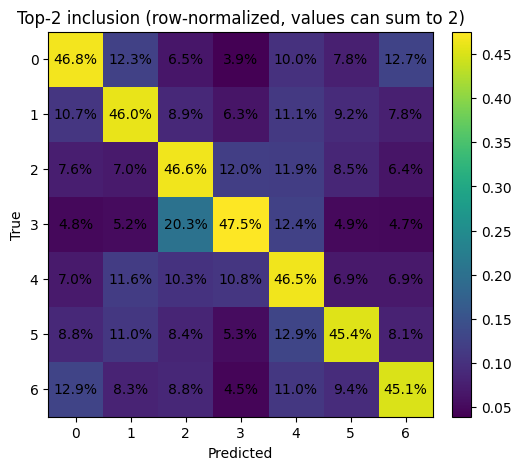

In [10]:
# Confusion matrices for top-1 accuracy and top-2 accuracy (vs hard labels y_action)
@torch.no_grad()
def eval_confusions(dl, device, k=2):
    model.eval()

    # infer number of classes from first batch
    x0, y0, _ = next(iter(dl))
    x0 = x0.to(device)
    logits0, _ = model(x0[:1])
    C = int(logits0.shape[1])

    cm_top1 = torch.zeros((C, C), dtype=torch.int64)   # rows=true, cols=pred(top1)
    cm_topk = torch.zeros((C, C), dtype=torch.int64)   # rows=true, cols=member of top-k

    total = 0
    correct1 = 0
    correctk = 0

    for x, y_action, _ in dl:
        x = x.to(device, non_blocking=True)
        y = y_action.to(device, non_blocking=True).long()

        logits, _ = model(x)

        pred1 = logits.argmax(dim=1)
        topk = logits.topk(k=min(k, C), dim=1).indices  # (B,k)

        total += y.numel()
        correct1 += (pred1 == y).sum().item()
        correctk += (topk == y.unsqueeze(1)).any(dim=1).sum().item()

        # --- top-1 confusion ---
        y_cpu = y.detach().cpu()
        p_cpu = pred1.detach().cpu()
        idx = y_cpu * C + p_cpu
        cm_top1 += torch.bincount(idx, minlength=C*C).view(C, C)

        # --- top-k "inclusion" matrix ---
        # For each sample, increment (true=y, col=j) for every j in the model's top-k set
        y_rep = y_cpu.unsqueeze(1).expand(-1, topk.size(1)).reshape(-1)
        topk_flat = topk.detach().cpu().reshape(-1)
        idxk = y_rep * C + topk_flat
        cm_topk += torch.bincount(idxk, minlength=C*C).view(C, C)

    metrics = {
        "n": total,
        "acc": correct1 / total,
        "top2_acc": correctk / total if k == 2 else correctk / total,
    }
    return metrics, cm_top1, cm_topk

def cm_to_df(cm, prefix="c"):
    C = cm.shape[0]
    cols = [f"{prefix}{i}" for i in range(C)]
    rows = [f"y{i}" for i in range(C)]
    return pd.DataFrame(cm.numpy(), index=rows, columns=cols)

def plot_cm(cm, title, normalize="true", annotate=True, pct_decimals=1):
    """normalize: None | 'true' (row) | 'pred' (col) | 'all'"""
    mat = cm.to(torch.float32)

    # normalize for plotting
    if normalize == "true":
        denom = mat.sum(dim=1, keepdim=True).clamp_min(1)
        mat = mat / denom
    elif normalize == "pred":
        denom = mat.sum(dim=0, keepdim=True).clamp_min(1)
        mat = mat / denom
    elif normalize == "all":
        mat = mat / mat.sum().clamp_min(1)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(mat.numpy())
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks(range(mat.shape[1]))
    ax.set_yticks(range(mat.shape[0]))

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # annotate with percentages (only meaningful when normalized)
    if annotate and normalize is not None:
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                v = float(mat[i, j].item())
                ax.text(j, i, f"{v*100:.{pct_decimals}f}%", ha="center", va="center")

    plt.show()


# Run on validation loader
metrics, cm_top1, cm_top2_incl = eval_confusions(dl_val, DEVICE, k=2)
display(pd.DataFrame([metrics]))

# Confusion matrix for top-1 predictions (standard)
display(cm_to_df(cm_top1, prefix="pred_"))

# "Top-2 inclusion matrix":
# row=y, col=j counts how often j appears in the model's top-2 set when the true label is y.
# (Each row sums to ~ 2 * count(y), unless k is clipped by C.)
display(cm_to_df(cm_top2_incl, prefix="in_top2_"))

# Plots (row-normalized)
plot_cm(cm_top1, "Top-1 confusion (row-normalized)", normalize="true")
plot_cm(cm_top2_incl, "Top-2 inclusion (row-normalized, values can sum to 2)", normalize="true")